In [2]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Conv1D, Flatten, MaxPooling1D, RepeatVector, \
    TimeDistributed, LayerNormalization, Dropout, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
import statsmodels.api as sm
from pmdarima import auto_arima
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [121]:
import tensorflow as tf

In [340]:
import quantstats as qs
import yfinance as yf
from datetime import datetime

In [182]:
tf.random.set_seed(7)

In [901]:
def read_data(path, dim_type, gold_data=None, fed_rate=None, use_percentage=1):
    '''
    读取数据(详细说明)
    '''
    df = pd.read_csv(path)
    data_len = df.shape[0]
    data = None
    if dim_type!='Multi':
        data = df[dim_type].values.reshape((data_len, 1))
    else:
        # Multi
        df["Date"]=pd.to_datetime(df["Date"], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
        #df['CO'] = df['Close'] - df['Open']
        #diff_data = df['CO'].values.reshape((data_len, 1))
        open_data = df["Open"].values.reshape((data_len, 1))
        high_data = df["High"].values.reshape((data_len, 1))
        low_data = df["Low"].values.reshape((data_len, 1))
        close_data = df["Close"].values.reshape((data_len, 1))
        volume_data = df["Volume"].values.reshape((data_len, 1))
        if gold_data is not None:
            gold_data['Date']=gold_data['Date'].dt.strftime('%Y-%m-%d')
            df['Gold']=df['Date']
            
            # calc the gold series
            df['Gold'] = df['Gold'].apply(lambda x: gold_data['Close'][x==gold_data['Date']].values[0] if x in gold_data['Date'].values else np.nan)  
            # fillna using interpolating
            df['Gold'] = df['Gold'].interpolate(limit_direction="both")

            gold_data_fill=df["Gold"].values.reshape((data_len, 1))
            if fed_rate is not None:
                fed_rate['DATE']=fed_rate['DATE'].dt.strftime('%Y-%m-%d')
                df['fed']=df['Date']
                
                # calc the gold series
                df['fed'] = df['fed'].apply(lambda x: fed_rate['FEDFUNDS'][x==fed_rate['DATE']].values[0] if x in fed_rate['DATE'].values else np.nan)  
                # fillna using interpolating
                df['fed'] = df['fed'].interpolate(limit_direction="both")
    
                fed_data=df["fed"].values.reshape((data_len, 1))
                data = np.hstack((close_data, open_data, high_data, low_data, volume_data, gold_data_fill, fed_data))
            else:
                data = np.hstack((close_data, open_data, high_data, low_data, volume_data, gold_data_fill))
        else:
            data = np.hstack((close_data, open_data, high_data, low_data, volume_data))
    return data[0:int(np.floor(data_len * use_percentage))], np.floor(data_len * use_percentage)


In [717]:
def split_sequence(sequence, dim_type, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of the input pattern
        end_ix = i + n_steps_in
        # find the end of the output pattern
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequence):
            break
        if dim_type == 'Multi':
            # gather input and output parts of the pattern
            seq_x = sequence[i:end_ix, 1:]
            seq_y = sequence[end_ix:out_end_ix, 0]
        else:
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def data_trasform(data, anti=False, scaler=None):
    '''
    说明以及例子
    MinMax data and anti MinMax data
    :param data: the data source
    :param model: MinMax and anti MinMax
    :param scaler: anti MinMax scaler
    :return: the transformed data

    '''
    if not anti:
        # 归一化
        # 创建一个空字典来存储每一列的 scaler
        scalers = {}
        # 归一化数据的容器
        normalized_data = np.zeros_like(data)
        # 循环每一列
        for i in range(data.shape[1]):  # data.shape[1] 是列的数量
            # 为每一列创建一个新的 MinMaxScaler
            scaler = MinMaxScaler()
            # 将列数据调整为正确的形状，即(-1, 1)
            column_data = data[:, i].reshape(-1, 1)
            # 拟合并转换数据
            normalized_column = scaler.fit_transform(column_data)
            # 将归一化的数据存回容器中
            normalized_data[:, i] = normalized_column.ravel()
            # 存储scaler以便后续使用
            scalers[i] = scaler
        # 现在 normalized_data 是完全归一化的数据
        # scalers 字典包含每一列的 MinMaxScaler 实例
        return normalized_data, scalers
    else:
        # 反归一化
        # 如果data是三维数组，去除最后一个维度
        if data.ndim == 3 and data.shape[2] == 1:
            data = data.squeeze(axis=2)

        restored_data = np.zeros_like(data)
        for i in range(data.shape[1]):  # 遍历所有列
            column_data = data[:, i].reshape(-1, 1)
            restored_data[:, i] = scaler.inverse_transform(column_data).ravel()
        return restored_data

def create_transformer_model(input_seq_length, output_seq_length, num_features, d_model, num_heads, ff_dim,
                             num_transformer_blocks, dropout_rate=0.1):
    inputs = Input(shape=(input_seq_length, num_features))

    x = Dense(d_model)(inputs)

    for _ in range(num_transformer_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)  # Dropout after attention
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = Dense(ff_dim, activation="relu")(x)
        ff_output = Dropout(dropout_rate)(ff_output)  # Dropout after first dense layer
        ff_output = Dense(d_model)(ff_output)

        x = LayerNormalization(epsilon=1e-6)(x + ff_output)

    outputs = Dense(output_seq_length)(x[:, -1, :])  # We take the last step's output for forecasting
    model = Model(inputs, outputs)
    return model

def create_model(model_type, n_features, n_steps_in, n_steps_out):
    '''
        create model
        :param model_type:  LSTM,BD LSTM(bidirectional LSTM),ED LSTM(Encoder-Decoder LSTM),CNN
        :param n_features:
        :param n_steps_in:
        :param n_steps_out:
        :return: the created model
    '''
    model = Sequential()
    adam_optimizer = Adam(learning_rate=0.001)
    if model_type == 'LSTM':
        # LSTM
        model.add(LSTM(100, activation='sigmoid', return_sequences=True, input_shape=(n_steps_in, n_features)))
        model.add(LSTM(100, activation='sigmoid'))
        model.add(Dense(n_steps_out))

    elif model_type == 'BD LSTM':
        # bidirectional LSTM
        model.add(Bidirectional(LSTM(50, activation='sigmoid'), input_shape=(n_steps_in, n_features)))
        model.add(Dense(n_steps_out))

    elif model_type == 'ED LSTM':
        # Encoder-Decoder LSTM
        # Encoder
        model.add(LSTM(100, activation='sigmoid', input_shape=(n_steps_in, n_features)))
        # Connector
        model.add(RepeatVector(n_steps_out))
        # Decoder
        model.add(LSTM(100, activation='sigmoid', return_sequences=True))
        model.add(TimeDistributed(Dense(1)))

    elif model_type == 'CNN':
        # CNN
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_steps_out))

    elif model_type == 'Convolutional LSTM':
        # Convolutional LSTM
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
        model.add(LSTM(20, activation='relu', return_sequences=False))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_steps_out))

    elif model_type == 'Transformer':
        model = create_transformer_model(n_steps_in, n_steps_out, n_features, d_model=64,
                                         num_heads=12, ff_dim=64, num_transformer_blocks=3)

    elif model_type == 'MLP':
        # 多层感知机 (MLP)
        model.add(Dense(20, activation='relu', input_shape=(n_steps_in, n_features)))
        model.add(Flatten())
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_steps_out))

    elif model_type == 'ARIMA':
        if n_features != 1:
            print("ARIMA model only supports univariate time series data")
            print("ARIMA model has no parameter n_steps_in")
            return None
        model = 'ARIMA'
        return model
    
    else:
        print("no model")
    model.compile(optimizer=adam_optimizer, loss='mse')
    return model


def train_and_forecast(model, n_features, dim_type, data_X, data_Y, n_steps_in, n_steps_out, ech):
    # 训练模型
    # 隐藏输出
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

    X, y = split_sequence(data_X, dim_type, n_steps_in, n_steps_out)
    # 对于多维数据，调整最后一个维度为特征数
    X = X.reshape((X.shape[0], X.shape[1], n_features))

#######################################################################################
    if model == 'ARIMA':
        # 检查数据是否平稳
        fig = plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(data_X.squeeze(), lags=40, ax=ax1)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(data_X, lags=40, ax=ax2)
        
        # # 自动确定 ARIMA 模型的参数
        # auto_model = auto_arima(data_X, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        # # 输出最佳 ARIMA 模型的参数
        # print(auto_model.summary())
        
        # 使用最佳参数拟合 ARIMA 模型
        # ARIMA 模型只接受单变量时间序列，这里假设 data_X 和 data_Y 是一维数组
        # order = auto_model.order
        order = (6,1,6)
        arma_model = ARIMA(data_X, order=order)
        model_fit = arma_model.fit()
        # 拟合结果
        fit_result = model_fit.fittedvalues
        # 使用模型进行滚动预测
        history = list(data_X)
        test_result = []
        for t in range(len(data_Y)):
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            output = model_fit.forecast(n_steps_out)
            test_result.append(output)
            history.append(data_Y[t])  # 更新历史数据
        test_result = np.array(test_result)
        fit_result = fit_result.reshape(len(fit_result), 1)
        return fit_result, test_result
#######################################################################################

    # 训练模型
    model.fit(X, y, epochs=ech, batch_size=32, verbose=1)

    # 拟合结果
    fit_result = []
    for index, ele in enumerate(X):
        print(f'Fitting {index}th data')
        pred = model.predict(ele.reshape((1, n_steps_in, n_features)))
        fit_result.append(pred)
    fr = np.array(fit_result)
    fit_result = fr.reshape(len(fit_result), n_steps_out)
    # 测试结果
    test_x, test_y = split_sequence(data_Y, dim_type, n_steps_in, n_steps_out)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], n_features))
    test_result = []
    for index, ele in enumerate(test_x):
        print(f'Predicting {index}th data')
        pred = model.predict(ele.reshape((1, n_steps_in, n_features)))
        test_result.append(pred)
    tr = np.array(test_result)
    test_result = tr.reshape(len(test_result), n_steps_out)

    # 恢复输出
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    return fit_result, test_result

def eval_result(result, n_steps_out, target, mode):
    '''
    evaluate the modl resule
    :param result:the model result
    :param n_steps_out:the days you predict
    :param target:the ground-true
    :param mode:the type of evaluation(you can choose 0：rmse,1：mape)
    :return:the evaluation result
    '''
    if mode==0:
        # return rmse result
        # 归一化
        result, _ = data_trasform(result)
        target, _ = data_trasform(target)
        # 下面需要修改
        rmse = []
        for i in range(n_steps_out):
            rmse.append(np.sqrt(np.mean((result[:, i] - target[:, i]) ** 2)))
        return rmse

    elif mode==1:
        # return MAPE result
        result = result + 0.0000001
        target = target + 0.0000001
        mape = []
        for i in range(n_steps_out):
            mape.append(np.mean(np.abs((target[:, i] - result[:, i]) / target[:, i])) * 100)
        return mape
    else:
        return None


In [718]:
# add the prediction column to the test_dataset
def update_prediction(test_dataset, test_result, n_steps_in):
    updateted_dataset = test_dataset[n_steps_in:]
    test_result_list = test_result.tolist()
    t_list = list()
    for i in range(len(test_result_list)):
        number = test_result_list[i][0]
        t_list.append(number)
    updateted_dataset['prediction'] = t_list 
    return updateted_dataset

In [14]:
bit_data = pd.read_csv(path)

In [15]:
bit_data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


# Run from here 

In [1208]:
gold = yf.download(tickers="GC=F")

start = datetime(2013, 4, 29)
end = datetime(2021, 7, 6)

filtered = gold[start: end]

In [1209]:
filtered = filtered.reset_index()

In [1210]:
filtered

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-04-29,1462.699951,1475.500000,1462.300049,1467.400024,1467.400024,269
1,2013-04-30,1471.099976,1476.599976,1461.000000,1472.199951,1472.199951,534
2,2013-05-01,1475.800049,1477.099976,1440.000000,1446.300049,1446.300049,131
3,2013-05-02,1459.000000,1471.199951,1453.500000,1467.699951,1467.699951,244
4,2013-05-03,1465.500000,1487.099976,1461.400024,1464.300049,1464.300049,68
...,...,...,...,...,...,...,...
2054,2021-06-29,1776.800049,1777.099976,1752.099976,1762.800049,1762.800049,419
2055,2021-06-30,1761.099976,1770.800049,1759.199951,1770.800049,1770.800049,51
2056,2021-07-01,1775.699951,1781.199951,1768.800049,1775.900024,1775.900024,44
2057,2021-07-02,1778.699951,1787.900024,1778.300049,1782.599976,1782.599976,23


In [1211]:
fed_rate = pd.read_csv('FEDFUNDS.csv')

In [1212]:
fed_rate["DATE"] = pd.to_datetime(fed_rate["DATE"])

In [1309]:
path = 'coin_Bitcoin.csv'
gold_data = None 
fed_rate = None 
dim_type = 'Close'
use_percentage = 1

n_steps_in = 5  # take prior 5 values as input 
n_steps_out = 1 # predict t+1 value 

percentage = 0.7  # 训练集百分比
epochs = 25  # 迭代次数
#rounds = 3  # Number of exp

In [1310]:
data, data_len = read_data(path, dim_type, gold_data, fed_rate, use_percentage)
data, scalers = data_trasform(data)

# split into train and test
train_set = data[0:int(np.floor(data_len * percentage))]  # 训练集
test_set = data[int(np.floor(data_len * percentage)):]  # 测试集

In [1311]:
# find the test dataset
test_bit_data = bit_data[int(np.floor(data_len * percentage)):]

In [1317]:
update_dataset_model = test_bit_data[n_steps_in:]

In [1313]:
n_features = len(train_set[0]) - 1 if len(train_set[0]) > 1 else 1 # features of the input 

In [1325]:
model_type =['LSTM', 'BD LSTM', 'CNN', 'MLP', 'ED LSTM', 'Convolutional LSTM']

In [1329]:
pred_name[6]

'prediction_ARIMA'

In [1327]:
for i in range(len(model_type)):
    model_use = model_type[i]
    Model = create_model(model_use, n_features, n_steps_in, n_steps_out)
    
    train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                    n_steps_out, epochs)
    
    # ----------------------evaluation--------------------
    train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
    test_result = data_trasform(test_result, True, scalers[0])  # 反归一化
    
    test_result_list = test_result.tolist()
    t_list = list()
    for j in range(len(test_result_list)):
        number = test_result_list[j][0]
        t_list.append(number)
    update_dataset_model[pred_name[i]] = t_list

In [1330]:
update_dataset_model[pred_name[6]] = t_list_ARIMA_updated

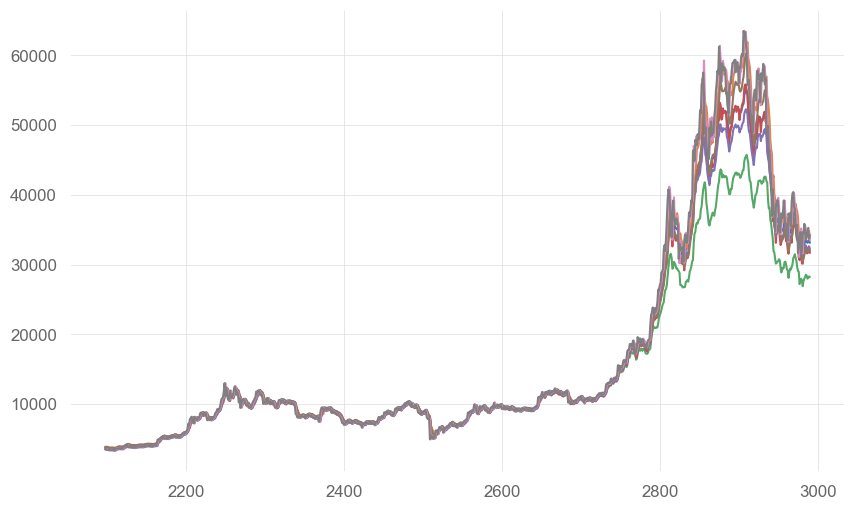

In [1336]:
for i in range(len(pred_name)):
    plt.plot(update_dataset_model[pred_name[i]])
plt.plot(update_dataset_model['Close'], color='grey')

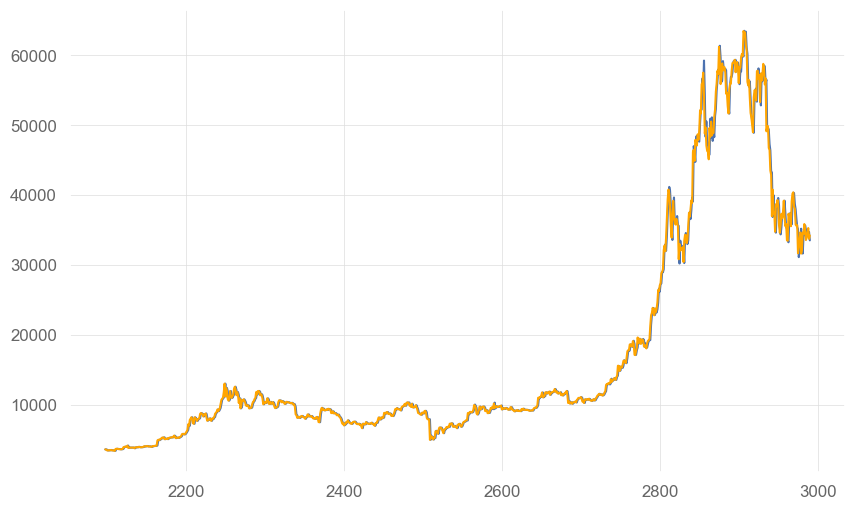

In [1348]:
plt.plot(update_dataset_model[pred_name[6]])
plt.plot(update_dataset_model['Close'], color='orange')

In [1349]:
update_dataset_model['pred_diff_ARIMA'] = update_dataset_model[pred_name[6]] - update_dataset_model['Open']

In [1343]:
for i in range(len(pred_name)):
    prediction_list = update_dataset_model[pred_name[i]].tolist()
    prediction_list = prediction_list[0:len(prediction_list)-1]
    new_predict_data[pred_open_name[i]] = prediction_list
    new_predict_data[pred_diff_name[i]] = new_predict_data[pred_name[i]] - new_predict_data[pred_open_name[i]]

'prediction_BD_LSTM'

In [1216]:
n_features = len(train_set[0]) - 1 if len(train_set[0]) > 1 else 1 # features of the input 

# Choose the model type 
model_type = 'LSTM' # Encoder-Decoder

Model = create_model(model_type, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

In [1217]:
test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)

In [1204]:
model_type_list = ['LSTM', 'BD LSTM', 'ED LSTM', 'CNN', 'Convolutional LSTM', 'Transformer', 'MLP']

In [1220]:
updateted_dataset = test_bit_data[n_steps_in:]

In [1221]:
updateted_dataset['prediction_LSTM'] = t_list

In [1224]:
model_type = 'BD LSTM' # Encoder-Decoder

Model = create_model(model_type, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)
updateted_dataset['prediction_BD_LSTM'] = t_list

In [1226]:
model_type = 'CNN' # CNN

Model = create_model(model_type, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)
updateted_dataset['prediction_CNN'] = t_list

In [1230]:
model_type = 'MLP' # CNN

Model = create_model(model_type, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)
updateted_dataset['prediction_MLP'] = t_list

In [1321]:
updateted_dataset

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2098,2099,Bitcoin,BTC,2019-01-26 23:59:59,3654.933193,3593.345837,3599.715363,3602.460439,5.098183e+09,6.305490e+10
2099,2100,Bitcoin,BTC,2019-01-27 23:59:59,3612.671428,3567.245758,3604.687267,3583.965763,5.570753e+09,6.273727e+10
2100,2101,Bitcoin,BTC,2019-01-28 23:59:59,3586.750878,3439.233009,3584.283279,3470.450542,6.908930e+09,6.075657e+10
2101,2102,Bitcoin,BTC,2019-01-29 23:59:59,3476.065364,3400.819726,3468.870155,3448.117022,5.897159e+09,6.037187e+10
2102,2103,Bitcoin,BTC,2019-01-30 23:59:59,3495.174888,3429.387948,3443.897062,3486.181751,5.955113e+09,6.104426e+10
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [1232]:
model_type = 'ED LSTM' # CNN

Model = create_model(model_type, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)
updateted_dataset['prediction_ED_LSTM'] = t_list

In [1233]:
model_type = 'Convolutional LSTM' # CNN

Model = create_model(model_type, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)
updateted_dataset['prediction_Convolutional_LSTM'] = t_list

# Prediction using ARIMA 

In [1236]:
path = 'coin_Bitcoin.csv'
gold_data_ARIMA = None  
fed_rate_ARIMA = None 
dim_type_ARIMA = 'Close'
use_percentage = 1

n_steps_in = 5  # take prior 5 values as input 
n_steps_out = 1 # predict t+1 value 

percentage = 0.7  # 训练集百分比
epochs = 25  # 迭代次数
#rounds = 3  # Number of exp

In [1237]:
data_ARIMA, data_len_ARIMA = read_data(path, dim_type_ARIMA, gold_data_ARIMA, fed_rate_ARIMA, use_percentage)
data_ARIMA, scalers_ARIMA = data_trasform(data_ARIMA)

# split into train and test
train_set_ARIMA = data_ARIMA[0:int(np.floor(data_len_ARIMA * percentage))]  # 训练集
test_set_ARIMA = data_ARIMA[int(np.floor(data_len_ARIMA * percentage)):]  # 测试集

In [1238]:
n_features_ARIMA = len(train_set_ARIMA[0]) - 1 if len(train_set_ARIMA[0]) > 1 else 1 # features of the input 

In [1240]:
model_type = 'ARIMA' # ARIMA

Model = create_model(model_type, n_features_ARIMA, n_steps_in, n_steps_out)

order = (6,1,6)
arma_model = ARIMA(train_set_ARIMA, order=order)
model_fit = arma_model.fit()
# 拟合结果
fit_result = model_fit.fittedvalues
# 使用模型进行滚动预测
history = list(train_set_ARIMA)
test_result = []
for t in range(len(test_set_ARIMA)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(n_steps_out)
    test_result.append(output)
    history.append(test_set_ARIMA[t])  
test_result = np.array(test_result)
fit_result = fit_result.reshape(len(fit_result), 1)

In [1241]:
# ----------------------evaluation--------------------
test_result_ARIMA = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list_ARIMA = test_result_ARIMA.tolist()
t_list_ARIMA = list()
for j in range(len(test_result_list_ARIMA)):
    number = test_result_list_ARIMA[j][0]
    t_list_ARIMA.append(number)

In [1243]:
len(t_list_ARIMA)

898

In [1244]:
test_bit_data['Prediction_ARIMA'] = t_list_ARIMA 

In [1251]:
t_list_ARIMA_updated =  t_list_ARIMA[5:]

In [1254]:
updateted_dataset['Prediction_ARIMA'] = t_list_ARIMA_updated

In [1258]:
updated_dataset = updateted_dataset.drop('Prediction_ARIMA', axis=1)

In [1260]:
updated_dataset['prediction_ARIMA'] = t_list_ARIMA_updated 

In [1261]:
updated_dataset

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,prediction_LSTM,prediction_BD_LSTM,prediction_CNN,prediction_MLP,prediction_ED_LSTM,prediction_Convolutional_LSTM,prediction_ARIMA
2098,2099,Bitcoin,BTC,2019-01-26 23:59:59,3654.933193,3593.345837,3599.715363,3602.460439,5.098183e+09,6.305490e+10,3621.333008,3990.042725,4278.281250,4278.878418,3766.638916,4006.976074,3599.765928
2099,2100,Bitcoin,BTC,2019-01-27 23:59:59,3612.671428,3567.245758,3604.687267,3583.965763,5.570753e+09,6.273727e+10,3629.129883,4000.709961,4284.929199,4249.747070,3774.661377,4001.366943,3602.460589
2100,2101,Bitcoin,BTC,2019-01-28 23:59:59,3586.750878,3439.233009,3584.283279,3470.450542,6.908930e+09,6.075657e+10,3633.517090,4008.982422,4271.763184,4288.499512,3777.396484,3995.621338,3583.965603
2101,2102,Bitcoin,BTC,2019-01-29 23:59:59,3476.065364,3400.819726,3468.870155,3448.117022,5.897159e+09,6.037187e+10,3637.650391,4009.576172,4252.998535,4263.714355,3778.167236,3976.501465,3470.450403
2102,2103,Bitcoin,BTC,2019-01-30 23:59:59,3495.174888,3429.387948,3443.897062,3486.181751,5.955113e+09,6.104426e+10,3573.468262,3947.504150,4217.374023,4158.437500,3703.855713,3943.257080,3448.117046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,32606.810547,34467.582031,18974.945312,18168.480469,32724.199219,25791.388672,34200.092512
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,32255.707031,34557.437500,18849.130859,17713.933594,32300.369141,25423.892578,34585.075415
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,32058.167969,34678.300781,18653.345703,17072.931641,32153.031250,25218.550781,34313.705583
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,32317.167969,34918.964844,18578.593750,17777.798828,32517.408203,25378.691406,34740.516032


In [1268]:
new_predict_data = updated_dataset[1:]

In [1449]:
model_type =['LSTM', 'BD_LSTM', 'CNN', 'MLP', 'ED_LSTM', 'Convolutional_LSTM', 'ARIMA']
pred_name = []
pred_open_name = []
pred_diff_name = []
daily_return_pred = []
for i in range(len(model_type)):
    column_name = 'prediction_' + model_type[i]
    column_name_open = 'pred_open_' + model_type[i]
    column_name_diff = 'pred_diff_' + model_type[i]
    column_name_return= 'daily_return_' + model_type[i]
    pred_name.append(column_name)
    pred_open_name.append(column_name_open)
    pred_diff_name.append(column_name_diff)
    daily_return_pred.append(column_name_return )



In [1271]:
pred_diff_name

['pred_diff_LSTM',
 'pred_diff_BD_LSTM',
 'pred_diff_CNN',
 'pred_diff_MLP',
 'pred_diff_ED_LSTM',
 'pred_diff_Convolutional_LSTM',
 'pred_diff_ARIMA']

In [1394]:
new_predict_data = update_dataset_model[1:]

In [1395]:
for i in range(len(pred_name)):
    pred_open_list = update_dataset_model[pred_name[i]].tolist()
    pred_open_list = pred_open_list[:len(pred_open_list)-1]
    new_predict_data[pred_open_name[i]] = pred_open_list
    new_predict_data[pred_diff_name[i]] = new_predict_data[pred_name[i]] - new_predict_data[pred_open_name[i]]

In [1396]:
new_predict_data 

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,pred_diff_BD_LSTM,pred_open_CNN,pred_diff_CNN,pred_open_MLP,pred_diff_MLP,pred_open_ED_LSTM,pred_diff_ED_LSTM,pred_open_Convolutional_LSTM,pred_diff_Convolutional_LSTM,pred_open_ARIMA
2099,2100,Bitcoin,BTC,2019-01-27 23:59:59,3612.671428,3567.245758,3604.687267,3583.965763,5.570753e+09,6.273727e+10,...,10.485352,3725.193359,2.248291,3687.318359,3.997559,3497.392578,3.330322,3903.776123,2.024414,3599.765928
2100,2101,Bitcoin,BTC,2019-01-28 23:59:59,3586.750878,3439.233009,3584.283279,3470.450542,6.908930e+09,6.075657e+10,...,-13.002930,3727.441650,-1.708252,3691.315918,-9.780518,3500.722900,-7.227539,3905.800537,-2.876465,3602.460589
2101,2102,Bitcoin,BTC,2019-01-29 23:59:59,3476.065364,3400.819726,3468.870155,3448.117022,5.897159e+09,6.037187e+10,...,-42.982666,3725.733398,-21.912842,3681.535400,-60.202148,3493.495361,-51.614990,3902.924072,-34.516846,3583.965603
2102,2103,Bitcoin,BTC,2019-01-30 23:59:59,3495.174888,3429.387948,3443.897062,3486.181751,5.955113e+09,6.104426e+10,...,-19.887207,3703.820557,-66.879639,3621.333252,-34.195557,3441.880371,-38.919678,3868.407227,-43.748291,3470.450403
2103,2104,Bitcoin,BTC,2019-01-31 23:59:59,3504.804885,3447.915815,3485.409290,3457.792747,5.831198e+09,6.055390e+10,...,5.286865,3636.940918,-19.188232,3587.137695,2.815674,3402.960693,-8.072754,3824.658936,-22.330078,3448.117046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,267.507812,28573.265625,-111.865234,32436.013672,-778.775391,32772.597656,-416.107422,32467.468750,-274.382812,35097.107656
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,0.085938,28461.400391,-461.949219,31657.238281,-15.484375,32356.490234,-144.650391,32193.085938,-308.167969,34200.092512
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,675.093750,27999.451172,124.917969,31641.753906,468.332031,32211.839844,197.876953,31884.917969,29.064453,34585.075415
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,-65.410156,28124.369141,203.744141,32110.085938,428.166016,32409.716797,247.259766,31913.982422,210.228516,34313.705583


In [1397]:
long_short_signal = []
for index, row in new_predict_data.iterrows():
    count = 0
    for i in range(len(pred_diff_name)):
        if row[pred_diff_name[i]] > 0:
            count += 1
        else:
            count = count 
    long_short_signal.append(count)
        

In [1398]:
new_predict_data['Diff_open_close'] = new_predict_data['Close'] - new_predict_data['Open']

In [1399]:
new_predict_data['long_short_signal'] = long_short_signal 

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,pred_open_CNN,pred_diff_CNN,pred_open_MLP,pred_diff_MLP,pred_open_ED_LSTM,pred_diff_ED_LSTM,pred_open_Convolutional_LSTM,pred_diff_Convolutional_LSTM,pred_open_ARIMA,long_short_signal
2099,2100,Bitcoin,BTC,2019-01-27 23:59:59,3612.671428,3567.245758,3604.687267,3583.965763,5.570753e+09,6.273727e+10,...,3725.193359,2.248291,3687.318359,3.997559,3497.392578,3.330322,3903.776123,2.024414,3599.765928,7
2100,2101,Bitcoin,BTC,2019-01-28 23:59:59,3586.750878,3439.233009,3584.283279,3470.450542,6.908930e+09,6.075657e+10,...,3727.441650,-1.708252,3691.315918,-9.780518,3500.722900,-7.227539,3905.800537,-2.876465,3602.460589,0
2101,2102,Bitcoin,BTC,2019-01-29 23:59:59,3476.065364,3400.819726,3468.870155,3448.117022,5.897159e+09,6.037187e+10,...,3725.733398,-21.912842,3681.535400,-60.202148,3493.495361,-51.614990,3902.924072,-34.516846,3583.965603,0
2102,2103,Bitcoin,BTC,2019-01-30 23:59:59,3495.174888,3429.387948,3443.897062,3486.181751,5.955113e+09,6.104426e+10,...,3703.820557,-66.879639,3621.333252,-34.195557,3441.880371,-38.919678,3868.407227,-43.748291,3470.450403,0
2103,2104,Bitcoin,BTC,2019-01-31 23:59:59,3504.804885,3447.915815,3485.409290,3457.792747,5.831198e+09,6.055390e+10,...,3636.940918,-19.188232,3587.137695,2.815674,3402.960693,-8.072754,3824.658936,-22.330078,3448.117046,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,28573.265625,-111.865234,32436.013672,-778.775391,32772.597656,-416.107422,32467.468750,-274.382812,35097.107656,1
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,28461.400391,-461.949219,31657.238281,-15.484375,32356.490234,-144.650391,32193.085938,-308.167969,34200.092512,2
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,27999.451172,124.917969,31641.753906,468.332031,32211.839844,197.876953,31884.917969,29.064453,34585.075415,6
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,28124.369141,203.744141,32110.085938,428.166016,32409.716797,247.259766,31913.982422,210.228516,34313.705583,6


In [1403]:
view_data = new_predict_data[['Diff_open_close', 'long_short_signal', pred_diff_name[6]]]

In [1404]:
view_data

,Diff_open_close,long_short_signal,pred_diff_ARIMA
2099,-20.721504,7,2.694661
2100,-113.832737,0,-18.494986
2101,-20.753133,0,-113.515200
2102,42.284689,0,-22.333358
2103,-27.616542,3,38.064890
...,...,...,...
2986,347.448412,1,-897.015143
2987,814.127040,2,384.982903
2988,622.214900,6,-271.369832
2989,-1538.341974,6,426.810449


In [1108]:
test_bit_data_prediction = update_prediction(test_bit_data, test_result, n_steps_in)

In [1111]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(test_bit_data_prediction['Close'], test_bit_data_prediction['prediction'], squared=False)

In [1112]:
rms

1654.3341602248272

In [1153]:
test_bit_data_prediction['pred_diff'] = test_bit_data_prediction['prediction'] - test_bit_data_prediction['Open']

In [1114]:
prediction_list = test_bit_data_prediction['prediction'].tolist()

In [1115]:
prediction_list = prediction_list[0: len(prediction_list)-1]

In [1116]:
new_predict_data = test_bit_data_prediction[1:int(np.floor(len(test_bit_data_prediction)))]

In [1117]:
new_predict_data['predict_open'] = prediction_list 

In [1118]:
new_predict_data['pred_diff'] = new_predict_data['prediction'] - new_predict_data['predict_open'] 

In [1405]:
def bit_strat_return(pred_df):
    daily_return_list = []
    for index, row in pred_df.iterrows():
        if row['long_short_signal'] > 3:
            daily_return =((row['Diff_open_close']) / row['Open'])
        else:
            daily_return = ((row['Diff_open_close']) * -1 / row['Open']) 
        daily_return_list.append(daily_return)
    return daily_return_list 

In [1406]:
daily_return_list = bit_strat_return(new_predict_data)

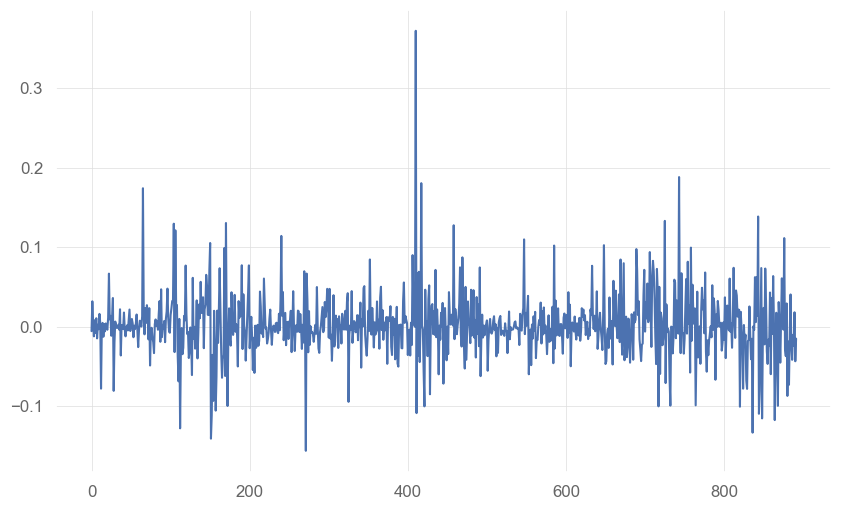

In [1407]:
plt.plot(daily_return_list)

In [1408]:
cum_daily_return = np.cumsum(daily_return_list)

In [1409]:
import matplotlib.dates as mdates

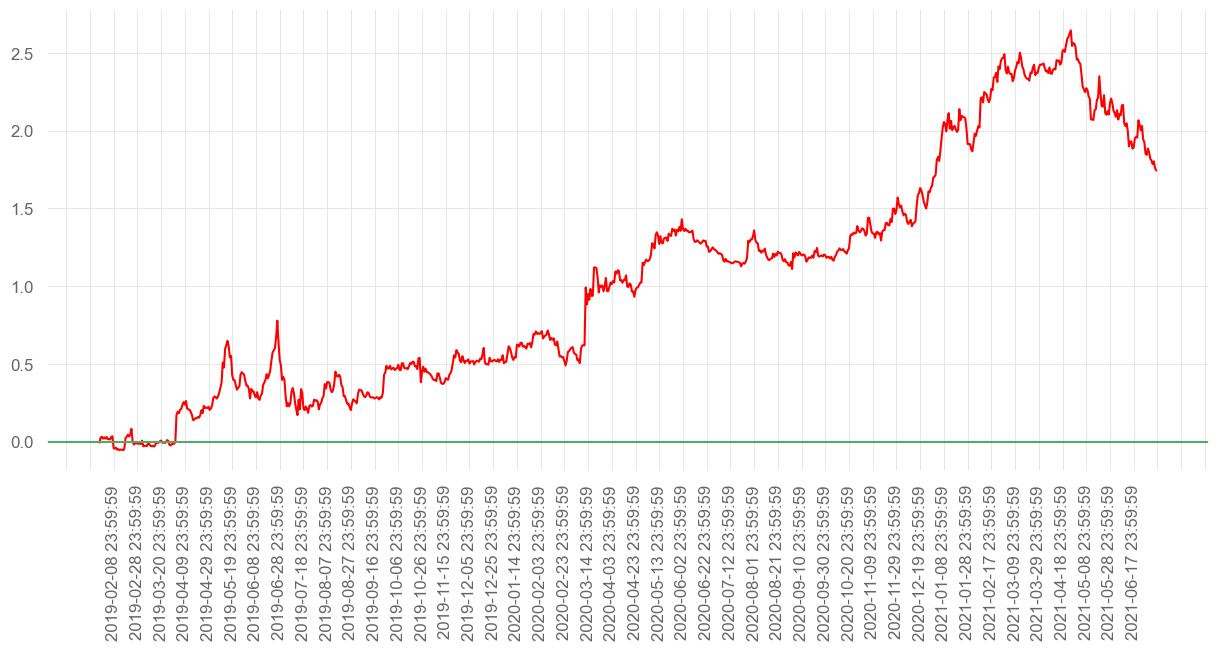

In [1411]:
plt.figure(figsize = (15, 6))
plt.plot(new_predict_data['Date'].tolist(), cum_daily_return, color ='red')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.axhline(y=0, color='g', linestyle='-')

In [1412]:
new_predict_data['daily_return'] = daily_return_list 

In [1413]:
report_data = new_predict_data[['Date', 'daily_return']]

In [1414]:
#with gzip.open(file_path, 'rt', encoding='utf_8') as f:
    #data = pd.read_csv(f, header=None)
#data_split = data[0].str.split('|', expand=True)

In [1415]:
report_data['Date'] = pd.to_datetime(report_data['Date'])
report_data['Date'] = [d.date() for d in report_data["Date"]]
report_data['Date'] = [pd.Timestamp(d) for d in report_data['Date']]
report_data = report_data.set_index(report_data['Date'])
daily_return_list = report_data['daily_return']
qs.stats.sharpe(daily_return_list)

In [1416]:
report_data['Date'] = [d.date() for d in report_data["Date"]]

In [1417]:
report_data['Date'] = [pd.Timestamp(d) for d in report_data['Date']]

In [1418]:
report_data = report_data.set_index(report_data['Date'])

In [1419]:
daily_return_list = report_data['daily_return']

In [1420]:
daily_return_list

Date
2019-01-27   -0.005748
2019-01-28    0.031759
2019-01-29    0.005983
2019-01-30   -0.012278
2019-01-31    0.007923
                ...   
2021-07-02   -0.010356
2021-07-03   -0.024048
2021-07-04    0.017949
2021-07-05   -0.043598
2021-07-06   -0.015173
Name: daily_return, Length: 892, dtype: float64

In [1421]:
#qs.reports.html(daily_return_list, 'SPY')

In [1422]:
qs.stats.sharpe(daily_return_list)

0.7814087992058966

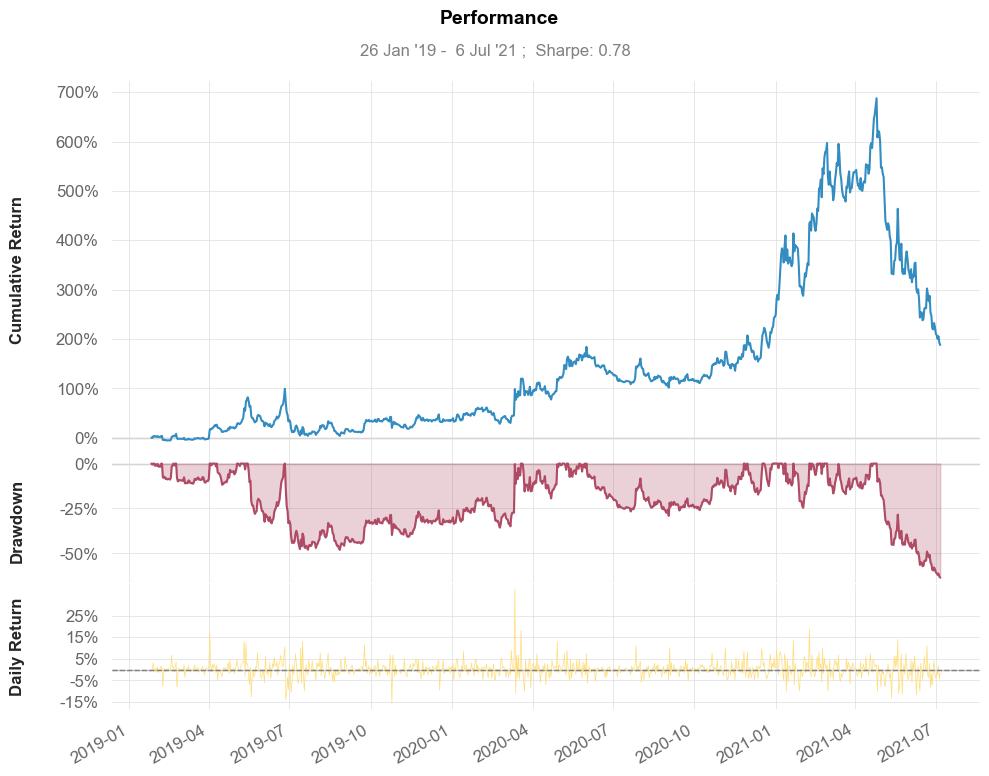

In [1423]:
qs.plots.snapshot(daily_return_list, title='Performance', show=True)

In [330]:
bit_data_all['return'] = diff_list 

In [334]:
bit_data_all['Date'] = [pd.Timestamp(d.date()) for d in pd.to_datetime(bit_data_all['Date'])]

In [1145]:
daily_return_list_all = []
for index, row in bit_data_all.iterrows():
    if row['diff'] > 0:
        daily_return =((row['diff'] ) / row['Open'])
    else:
        daily_return = ((row['diff']*-1) / row['Open']) 
    daily_return_list_all.append(daily_return)

In [1146]:
bit_data_all['daily_return'] =  daily_return_list_all 

In [336]:
bit_data_all = bit_data_all.set_index(bit_data_all['Date'])

In [1148]:
bit_data_return = bit_data_all['daily_return']

In [1149]:
bit_data_return

Date
2013-04-29    0.075094
2013-04-30    0.034722
2013-05-01    0.158345
2013-05-02    0.095979
2013-05-03    0.080000
                ...   
2021-07-02    0.010356
2021-07-03    0.024048
2021-07-04    0.017949
2021-07-05    0.043598
2021-07-06    0.015173
Name: daily_return, Length: 2991, dtype: float64

In [1150]:
qs.stats.sharpe(bit_data_return)

13.014213107542222

In [1424]:
new_predict_data 

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,pred_diff_CNN,pred_open_MLP,pred_diff_MLP,pred_open_ED_LSTM,pred_diff_ED_LSTM,pred_open_Convolutional_LSTM,pred_diff_Convolutional_LSTM,pred_open_ARIMA,long_short_signal,daily_return
2099,2100,Bitcoin,BTC,2019-01-27 23:59:59,3612.671428,3567.245758,3604.687267,3583.965763,5.570753e+09,6.273727e+10,...,2.248291,3687.318359,3.997559,3497.392578,3.330322,3903.776123,2.024414,3599.765928,7,-0.005748
2100,2101,Bitcoin,BTC,2019-01-28 23:59:59,3586.750878,3439.233009,3584.283279,3470.450542,6.908930e+09,6.075657e+10,...,-1.708252,3691.315918,-9.780518,3500.722900,-7.227539,3905.800537,-2.876465,3602.460589,0,0.031759
2101,2102,Bitcoin,BTC,2019-01-29 23:59:59,3476.065364,3400.819726,3468.870155,3448.117022,5.897159e+09,6.037187e+10,...,-21.912842,3681.535400,-60.202148,3493.495361,-51.614990,3902.924072,-34.516846,3583.965603,0,0.005983
2102,2103,Bitcoin,BTC,2019-01-30 23:59:59,3495.174888,3429.387948,3443.897062,3486.181751,5.955113e+09,6.104426e+10,...,-66.879639,3621.333252,-34.195557,3441.880371,-38.919678,3868.407227,-43.748291,3470.450403,0,-0.012278
2103,2104,Bitcoin,BTC,2019-01-31 23:59:59,3504.804885,3447.915815,3485.409290,3457.792747,5.831198e+09,6.055390e+10,...,-19.188232,3587.137695,2.815674,3402.960693,-8.072754,3824.658936,-22.330078,3448.117046,3,0.007923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,-111.865234,32436.013672,-778.775391,32772.597656,-416.107422,32467.468750,-274.382812,35097.107656,1,-0.010356
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,-461.949219,31657.238281,-15.484375,32356.490234,-144.650391,32193.085938,-308.167969,34200.092512,2,-0.024048
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,124.917969,31641.753906,468.332031,32211.839844,197.876953,31884.917969,29.064453,34585.075415,6,0.017949
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,203.744141,32110.085938,428.166016,32409.716797,247.259766,31913.982422,210.228516,34313.705583,6,-0.043598


In [1431]:
accuarcy_data = []
for i in range(len(pred_diff_name)):
    count = 0
    for index, row in new_predict_data.iterrows():
        if np.sign(row[pred_diff_name[i]]) == np.sign(row['Diff_open_close']):
            count += 1
        else:
            count = count
    accuarcy_rate = count / len(new_predict_data)
    accuarcy_data.append(accuarcy_rate)
            

In [1432]:
accuarcy_data

[0.5,
 0.4943946188340807,
 0.484304932735426,
 0.4786995515695067,
 0.4977578475336323,
 0.5067264573991032,
 0.47085201793721976]

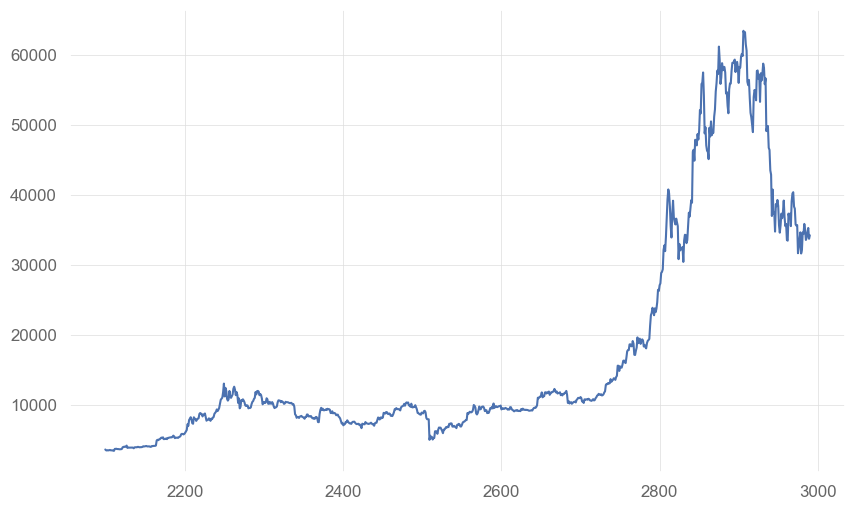

In [1433]:
plt.plot(new_predict_data['Close'])
plt.plot(nee_predict_data

In [1445]:
pred_name 

['prediction_LSTM',
 'prediction_BD_LSTM',
 'prediction_CNN',
 'prediction_MLP',
 'prediction_ED_LSTM',
 'prediction_Convolutional_LSTM',
 'prediction_ARIMA']

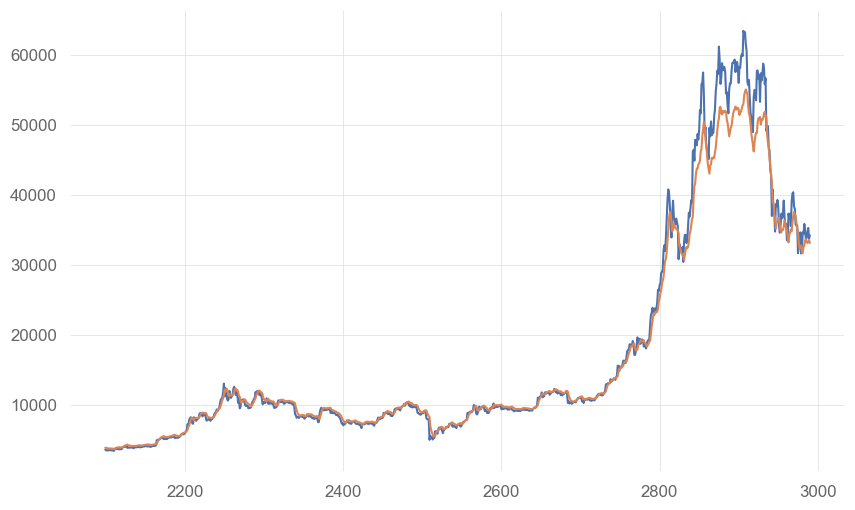

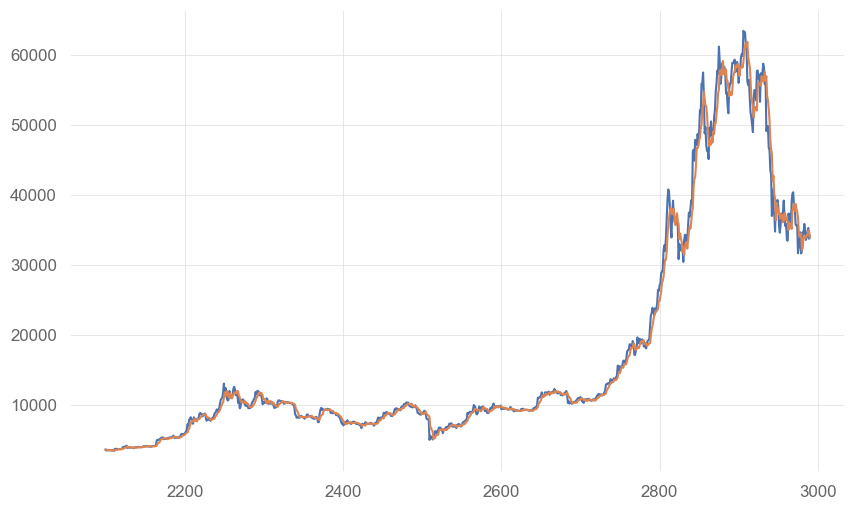

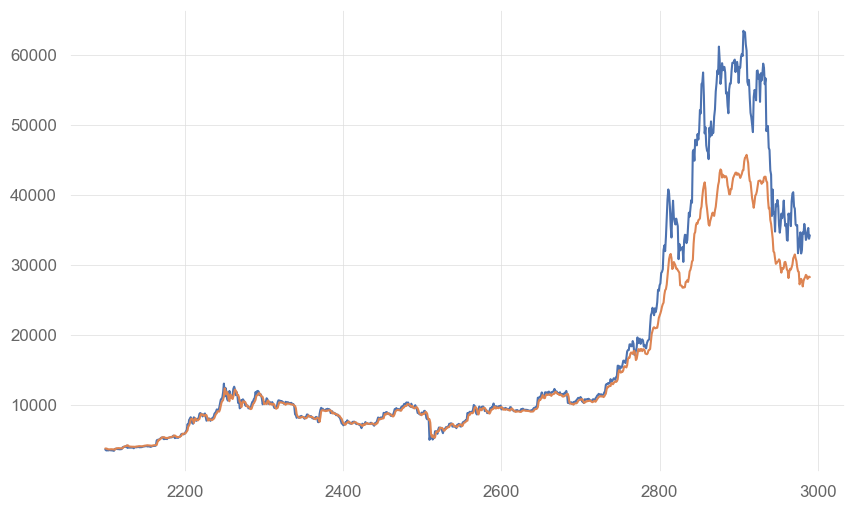

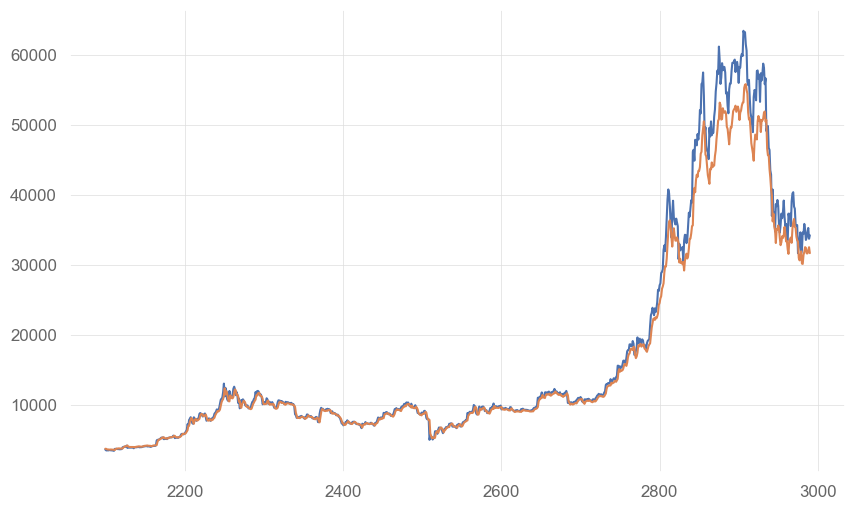

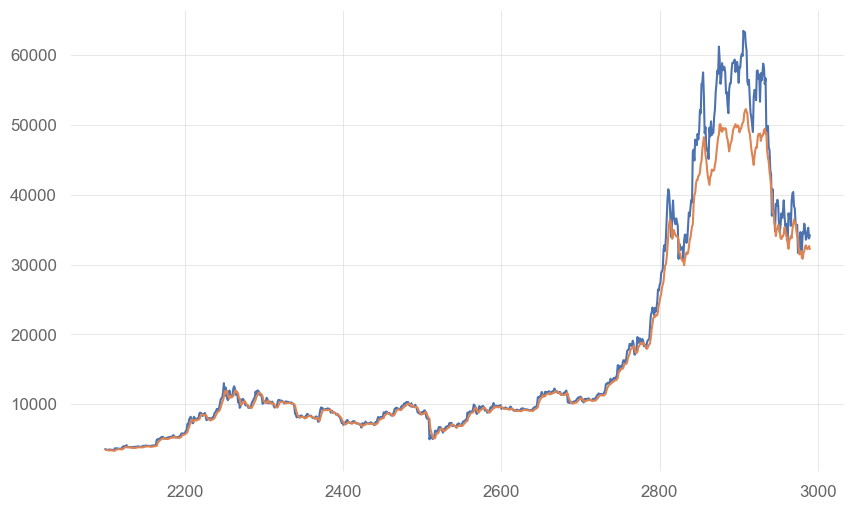

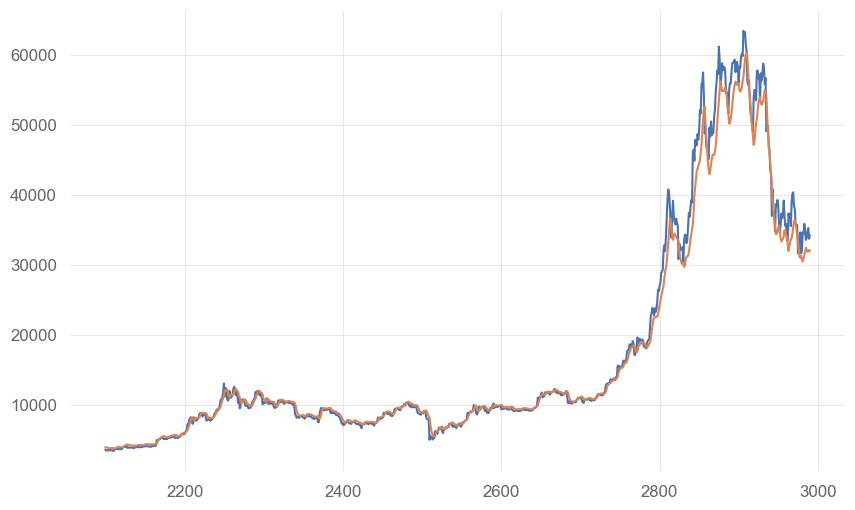

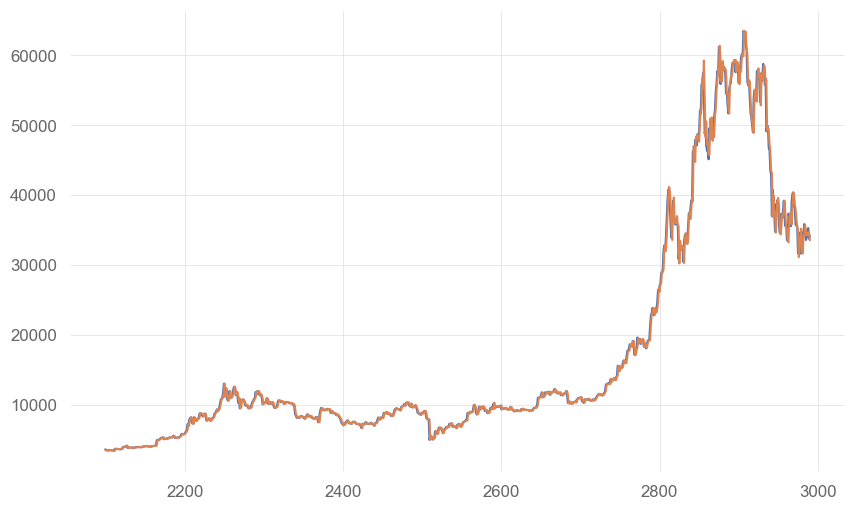

In [1446]:
f1 = plt.figure()
f2 = plt.figure()
f3 = plt.figure()
f4 = plt.figure()
f5 = plt.figure()
f6 = plt.figure()
f7 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(new_predict_data['Close'])
ax1.plot(new_predict_data[pred_name[0]])
ax2 = f2.add_subplot(111)
ax2.plot(new_predict_data['Close'])
ax2.plot(new_predict_data[pred_name[1]])
ax3 = f3.add_subplot(111)
ax3.plot(new_predict_data['Close'])
ax3.plot(new_predict_data[pred_name[2]])
ax4 = f4.add_subplot(111)
ax4.plot(new_predict_data['Close'])
ax4.plot(new_predict_data[pred_name[3]])
ax5 = f5.add_subplot(111)
ax5.plot(new_predict_data['Close'])
ax5.plot(new_predict_data[pred_name[4]])
ax6 = f6.add_subplot(111)
ax6.plot(new_predict_data['Close'])
ax6.plot(new_predict_data[pred_name[5]])
ax7 = f7.add_subplot(111)
ax7.plot(new_predict_data['Close'])
ax7.plot(new_predict_data[pred_name[6]])
plt.show()

In [1447]:
new_predict_data 

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,pred_diff_CNN,pred_open_MLP,pred_diff_MLP,pred_open_ED_LSTM,pred_diff_ED_LSTM,pred_open_Convolutional_LSTM,pred_diff_Convolutional_LSTM,pred_open_ARIMA,long_short_signal,daily_return
2099,2100,Bitcoin,BTC,2019-01-27 23:59:59,3612.671428,3567.245758,3604.687267,3583.965763,5.570753e+09,6.273727e+10,...,2.248291,3687.318359,3.997559,3497.392578,3.330322,3903.776123,2.024414,3599.765928,7,-0.005748
2100,2101,Bitcoin,BTC,2019-01-28 23:59:59,3586.750878,3439.233009,3584.283279,3470.450542,6.908930e+09,6.075657e+10,...,-1.708252,3691.315918,-9.780518,3500.722900,-7.227539,3905.800537,-2.876465,3602.460589,0,0.031759
2101,2102,Bitcoin,BTC,2019-01-29 23:59:59,3476.065364,3400.819726,3468.870155,3448.117022,5.897159e+09,6.037187e+10,...,-21.912842,3681.535400,-60.202148,3493.495361,-51.614990,3902.924072,-34.516846,3583.965603,0,0.005983
2102,2103,Bitcoin,BTC,2019-01-30 23:59:59,3495.174888,3429.387948,3443.897062,3486.181751,5.955113e+09,6.104426e+10,...,-66.879639,3621.333252,-34.195557,3441.880371,-38.919678,3868.407227,-43.748291,3470.450403,0,-0.012278
2103,2104,Bitcoin,BTC,2019-01-31 23:59:59,3504.804885,3447.915815,3485.409290,3457.792747,5.831198e+09,6.055390e+10,...,-19.188232,3587.137695,2.815674,3402.960693,-8.072754,3824.658936,-22.330078,3448.117046,3,0.007923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,-111.865234,32436.013672,-778.775391,32772.597656,-416.107422,32467.468750,-274.382812,35097.107656,1,-0.010356
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,-461.949219,31657.238281,-15.484375,32356.490234,-144.650391,32193.085938,-308.167969,34200.092512,2,-0.024048
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,124.917969,31641.753906,468.332031,32211.839844,197.876953,31884.917969,29.064453,34585.075415,6,0.017949
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,203.744141,32110.085938,428.166016,32409.716797,247.259766,31913.982422,210.228516,34313.705583,6,-0.043598


In [ ]:
def bit_strat_return(pred_df):
    daily_return_list = []
    for index, row in pred_df.iterrows():
        if row['long_short_signal'] > 3:
            daily_return =((row['Diff_open_close']) / row['Open'])
        else:
            daily_return = ((row['Diff_open_close']) * -1 / row['Open']) 
        daily_return_list.append(daily_return)
    return daily_return_list 

In [1451]:
daily_return_pred

['daily_return_LSTM',
 'daily_return_BD_LSTM',
 'daily_return_CNN',
 'daily_return_MLP',
 'daily_return_ED_LSTM',
 'daily_return_Convolutional_LSTM',
 'daily_return_ARIMA']

In [1452]:
for i in range(len(daily_return_pred)):
    daily_return_list = []
    for index, row in new_predict_data.iterrows():
        if row[pred_diff_name[i]] > 0:
            daily_return =((row['Diff_open_close']) / row['Open'])
        else:
            daily_return = ((row['Diff_open_close']) * -1 / row['Open']) 
        daily_return_list.append(daily_return)
    new_predict_data[daily_return_pred[i]] = daily_return_list 

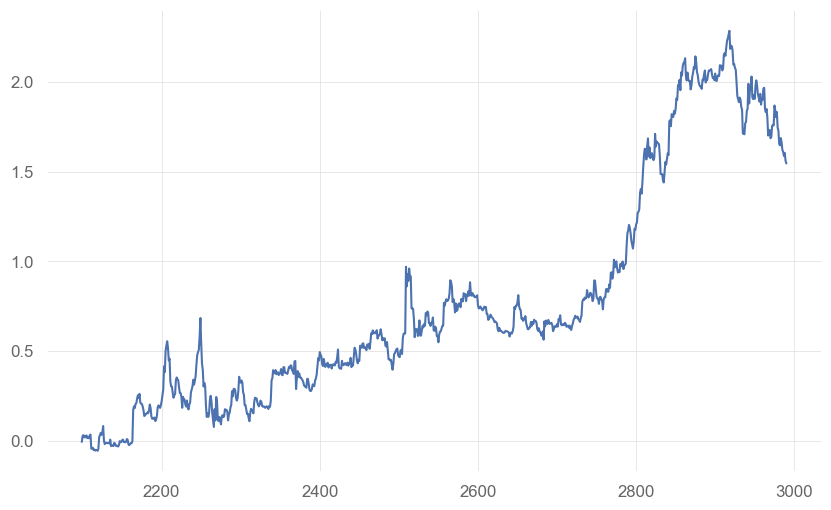

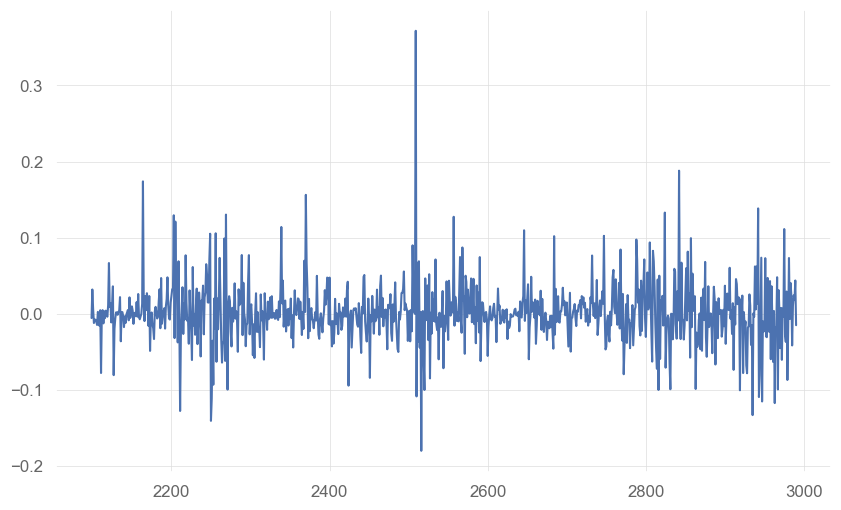

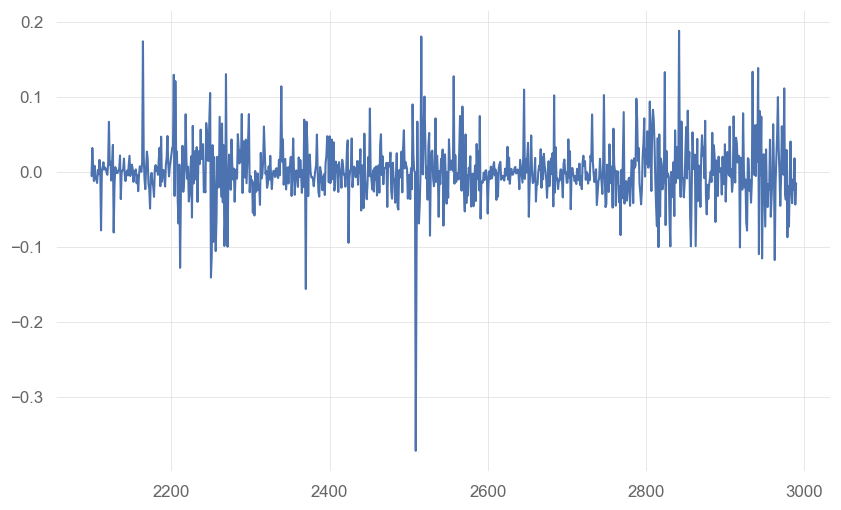

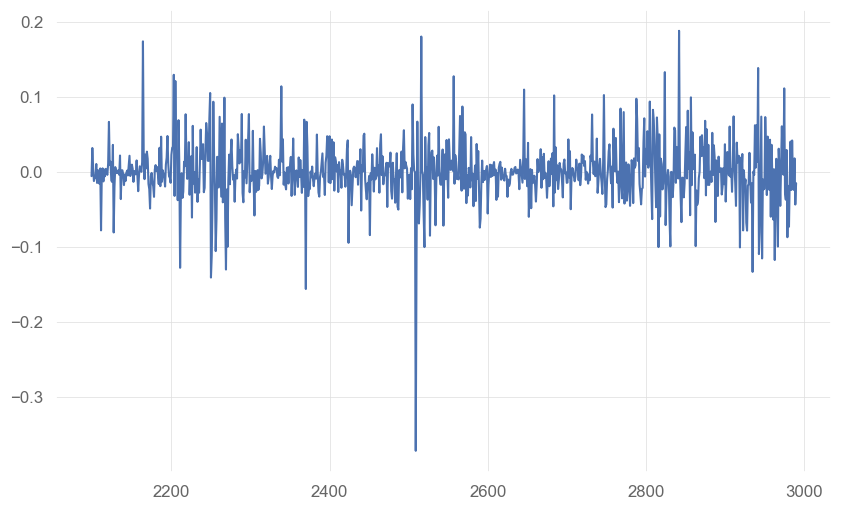

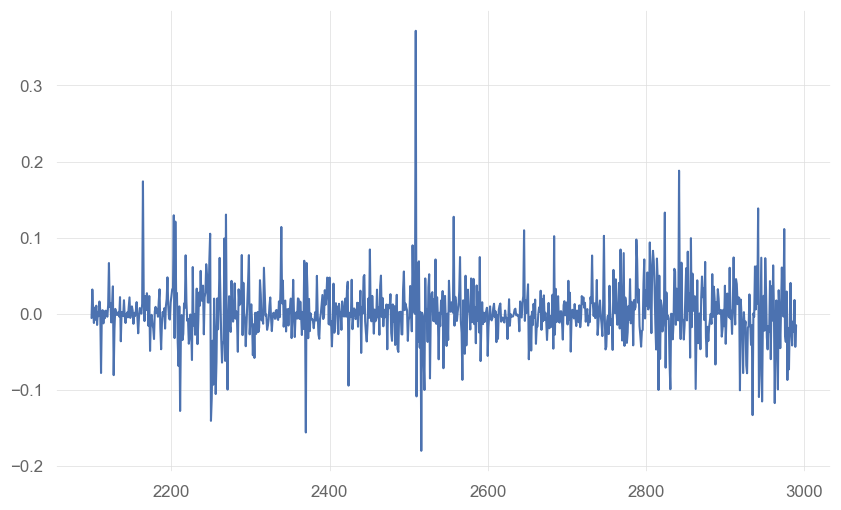

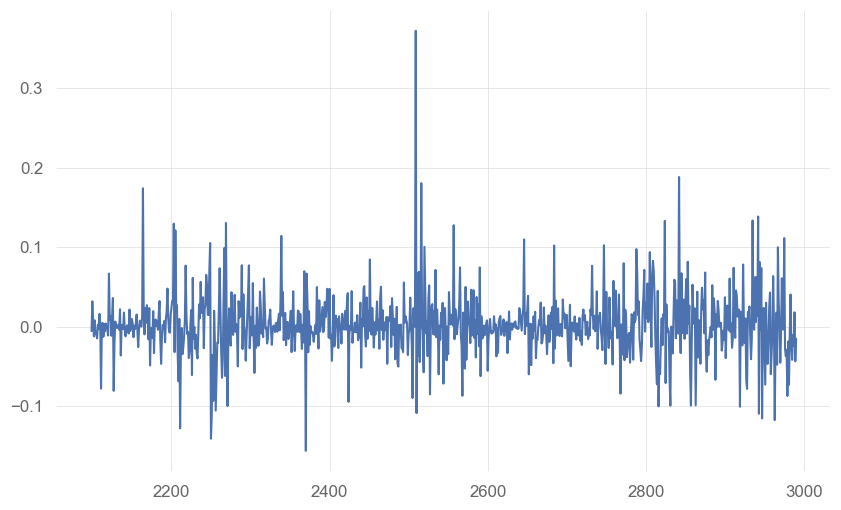

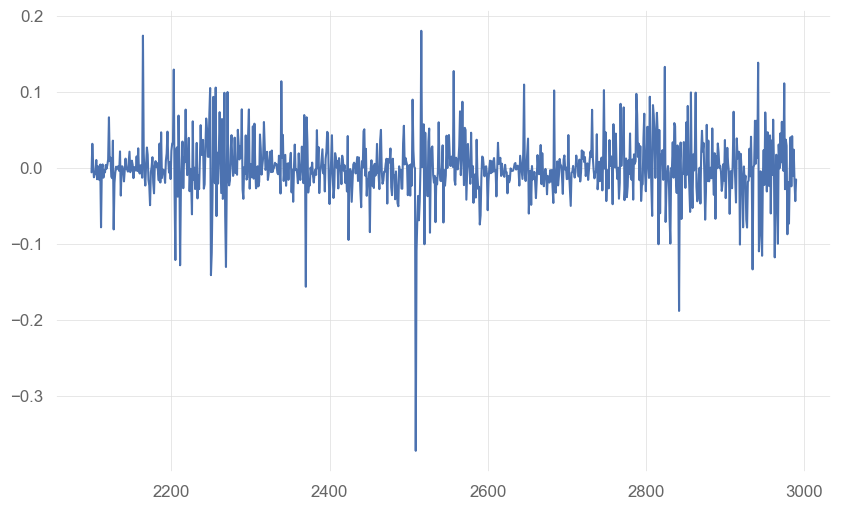

In [1456]:
f1 = plt.figure()
f2 = plt.figure()
f3 = plt.figure()
f4 = plt.figure()
f5 = plt.figure()
f6 = plt.figure()
f7 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(np.cumsum(new_predict_data[daily_return_pred[0]]))
ax2 = f2.add_subplot(111)
ax2.plot(new_predict_data[daily_return_pred[1]])
ax3 = f3.add_subplot(111)
ax3.plot(new_predict_data[daily_return_pred[2]])
ax4 = f4.add_subplot(111)
ax4.plot(new_predict_data[daily_return_pred[3]])
ax5 = f5.add_subplot(111)
ax5.plot(new_predict_data[daily_return_pred[4]])
ax6 = f6.add_subplot(111)
ax6.plot(new_predict_data[daily_return_pred[5]])
ax7 = f7.add_subplot(111)
ax7.plot(new_predict_data[daily_return_pred[6]])
plt.show()

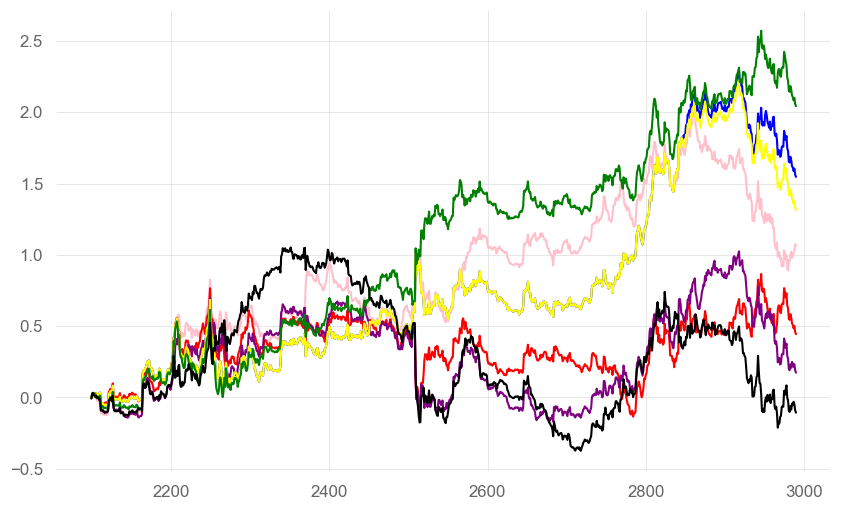

In [1461]:
plt.plot(np.cumsum(new_predict_data[daily_return_pred[0]]), color = 'blue')
plt.plot(np.cumsum(new_predict_data[daily_return_pred[1]]), color = 'pink')
plt.plot(np.cumsum(new_predict_data[daily_return_pred[2]]), color = 'red')
plt.plot(np.cumsum(new_predict_data[daily_return_pred[3]]), color = 'purple')
plt.plot(np.cumsum(new_predict_data[daily_return_pred[4]]), color = 'yellow')
plt.plot(np.cumsum(new_predict_data[daily_return_pred[5]]), color = 'green')
plt.plot(np.cumsum(new_predict_data[daily_return_pred[6]]), color = 'black')

NameError: name 'pred_diff_name' is not defined

In [1496]:
daily_return_combine = new_predict_data[daily_return_pred[5]] + (-1 * new_predict_data[daily_return_pred[2]]) 

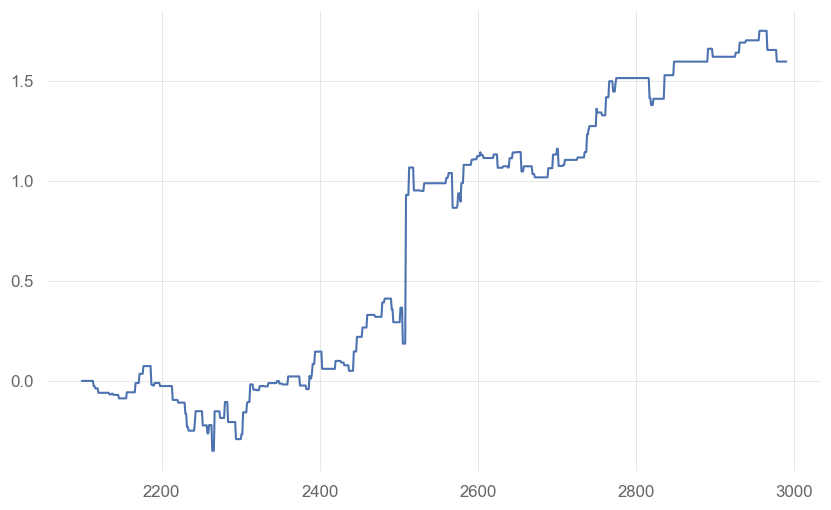

In [1497]:
plt.plot(np.cumsum(daily_return_combine))

In [1498]:
new_predict_data['daily_return_combine'] = daily_return_combine 
report_data = new_predict_data[['Date', 'daily_return_combine']]
report_data['Date'] = pd.to_datetime(report_data['Date'])
report_data['Date'] = [d.date() for d in report_data["Date"]]
report_data['Date'] = [pd.Timestamp(d) for d in report_data['Date']]
report_data = report_data.set_index(report_data['Date'])
daily_return_list = report_data['daily_return_combine']
qs.stats.sharpe(daily_return_list)

0.844027052949962

In [1499]:
qs.reports.html(daily_return_list, 'SPY')

In [1502]:
report_data = new_predict_data[['Date', daily_return_pred[5]]]
report_data['Date'] = pd.to_datetime(report_data['Date'])
report_data['Date'] = [d.date() for d in report_data["Date"]]
report_data['Date'] = [pd.Timestamp(d) for d in report_data['Date']]
report_data = report_data.set_index(report_data['Date'])
daily_return_list = report_data[daily_return_pred[5]]
qs.stats.sharpe(daily_return_list)

0.9152564458157361

In [1503]:
qs.reports.html(daily_return_list, 'SPY')